In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import ibl_tools
from ibl_tools.core_files import ExperimentNames, ExperimentFiles
from ibl_tools.plot import visualize_frames
from ibl_tools.util import quantile_scaling
import os

# Read all experiments
experiment = ExperimentNames()

# Select subset of experiments for demo
experiment_names = ['b8875d4d-e28f-4976-859e-bf8a5dd20024_paws_small',
 'cf7972dd-e408-4759-a3e2-e404a71f13ee_paws_small',
 '735c72f4-1b43-4eb6-8754-f2e2705cdcca_paws_small',
 'b1c80c88-4e4b-4651-966c-10d3eaf9b99e_paws_small',
 'fafe6343-d1d5-4979-814b-6024e97ffb89_paws_small']

In [2]:
# Extract data of subject ii
ii = 2
subject_id = experiment_names[ii]

In [3]:
trace_outliers = {0: ([50, 420],[100, 400]),
                  1: ([50, 420],[100, 400]),
                  2: ([ 50, 420],[100, 400]),
                  3: ([ 50, 420],[50, 400]),
                  4: ([ 50, 420],[50, 400])
                 }

([x_min, x_max], [y_min, y_max]) = trace_outliers[ii]
print(x_min, x_max)
print(y_min, y_max)

50 420
100 400


In [4]:
# Read.Create filenames for subject
exp_files = ExperimentFiles(subject_id, ii)

/run/user/1000/gvfs/smb-share:server=locker-smb.engram.rc.zi.columbia.edu,share=paninski-locker,user=ADCU%5Cekb2154/data/ibl/dlc-networks


In [5]:
# Load traces from a body bart (right paw)
(xr, yr, lr, namer) = exp_files.load_trace_raw()

['middle_finger_r', 'pinky_r', 'pointer_finger_r', 'ring_finger_r']

Parts in group: ' (\w+finger_r|pinky_r) ': 
middle_finger_r
pinky_r
pointer_finger_r
ring_finger_r


In [6]:
# Load video_clip
clip = exp_files.load_video_raw()

1579


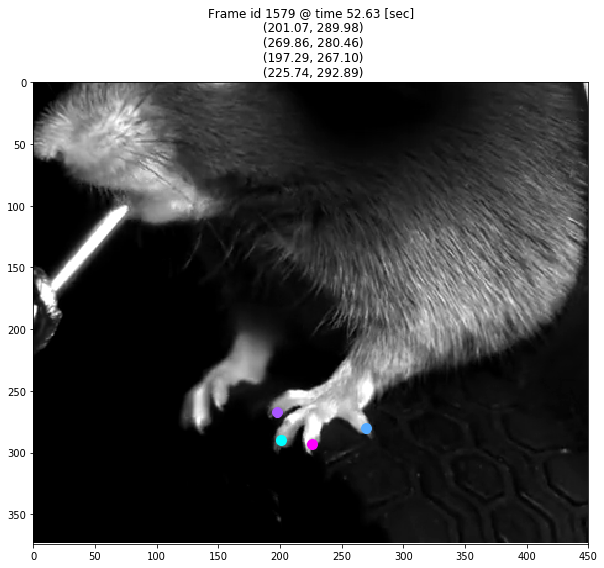

In [7]:
# Visualize frame
visualize_frames(clip, xr, yr,t0=1579)

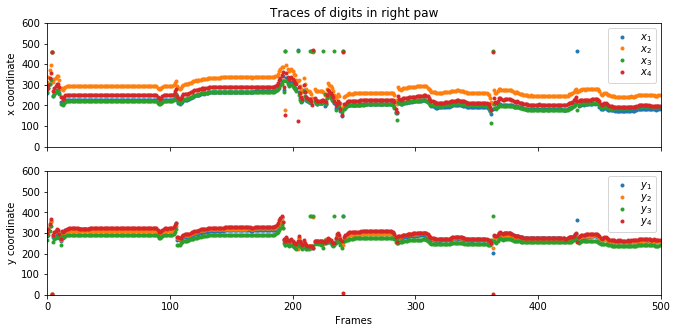

In [8]:
# Visualize trace
D_obs, _ = xr.shape

t0 = 1200
t = range(t0, t0+500)
fig, ax = plt.subplots(2, 1, figsize=(11, 5), sharex=True)

ax[0].set_title('Traces of digits in right paw')
for d in range(D_obs):
    ax[0].plot(xr[d, t], '.', label='$ x_{}$'.format(d+1))
    ax[0].set_ylim([0, 600])
    ax[0].set_xlim([0, len(t)])
    ax[0].legend(bbox_to_anchor=(1, 1), labelspacing=0)
    ax[0].set_ylabel(' x coordinate')
    
    
for d in range(D_obs):
    ax[1].plot(yr[d, t], '.', label='$y_{}$'.format(d+1))
    ax[1].set_ylim([0, 600])
    ax[1].set_xlim([0, len(t)])
    ax[1].legend(bbox_to_anchor=(1, 1), labelspacing=0)
    ax[1].set_ylabel('y coordinate')

plt.xlabel('Frames')
plt.show()

In [9]:
# Identify possible outliers

# Find markers outside quantiles
quantile = False
if quantile:
    xrmp, _, _ = quantile_scaling(xr)
    yrmp, _, _ = quantile_scaling(yr)

    mask_x = (np.abs(xrmp)> 2.5)
    mask_y = (np.abs(yrmp)> 2.5)
else:
    mask_x = np.zeros(xr.shape).astype('bool')
    mask_y = np.zeros(xr.shape).astype('bool')
    
# Find markers with large jumps
jump = True
jump_threshold = 100

if jump:
    dx = np.abs(np.diff(xr, 1))
    dy = np.abs(np.diff(yr, 1))
    dx = np.hstack((dx[:,0][:,None],dx))
    dy = np.hstack((dy[:,0][:,None],dy))
    mask_jump = (dx > jump_threshold) | (dy > jump_threshold)
else:
    mask_jump = np.zeros(xr.shape)

In [10]:
# include markers outside of regions of interest
mask_x = (mask_x) | (xr < x_min) | (xr > x_max) 
mask_y = (mask_y) | (yr < y_min) | (yr > y_max)
# errors are shared across axis
mask = ~(mask_x | mask_y | mask_jump).T
# shared mask for x and y 
mask = np.hstack((mask, mask))

In [11]:
# allocate x,y into single array
data = np.hstack((xr.T, yr.T))

In [12]:
# Use a LDS to smooth data
import ssm
N = data.shape[1] # number of observed dimensions
D = 2 # number of latent dimensions
Num_iters = 20 # number of iterations
#Create the model and initilize its parameters
lds = ssm.LDS(N, D, emissions="gaussian_orthog")
lds.initialize(data, masks=mask)

# Create a variational posterior
q_mf_elbos, q_mf = lds.fit(data, method="bbvi",
                            variational_posterior="lds", num_iters=Num_iters,
                           initialize=False,
                           masks=mask)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

Initializing with an ARHMM using 25 steps of EM.


In [13]:
# Smooth the data under the variational posterior
q_mf_y = lds.smooth(q_mf_x, data, mask=mask)

In [14]:
# Based on these, calculate mean paw position
xr_hat = q_mf_y[:, :4].T
yr_hat = q_mf_y[:, 4:].T

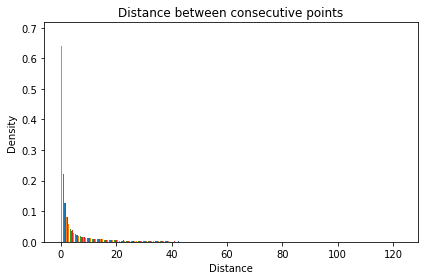

In [15]:
# Evaluate the jump distribution for markers
dx = np.diff(xr_hat,1)
dy = np.diff(yr_hat,1)
dx = np.hstack((dx[:,0][:,None],dx))
dy = np.hstack((dy[:,0][:,None],dy))
dxy = np.sqrt(dx**2 + dy**2)
plt.figure()
plt.title('Distance between consecutive points')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.hist(dxy.T, density=True, bins=200)
plt.tight_layout()
plt.show()
def z_score(x, th=3):
    return np.abs(x) > np.mean(x) + th*np.std(x)
#mask_jump = z_score(dx) | z_score(dy)

In [16]:
print('Max jump {}'.format(np.abs(dx).max(1)))
frame_idx = np.argmax(np.abs(dx),1)
print('Max jump @ frame {}'.format(frame_idx))

Max jump [ 90.0107892  100.08633256  82.7270689   97.36252644]
Max jump @ frame [46948 46948  1956 46948]


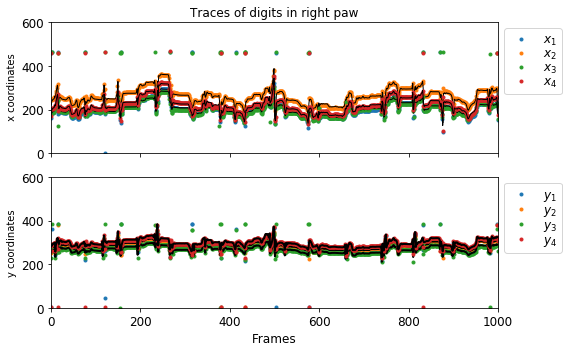

In [17]:
_, D_obs = q_mf_y.shape
fontsize = 12
t0 = frame_idx[0] - 500
t = range(t0, t0+1000)
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax[0].set_title('Traces of digits in right paw', fontsize=fontsize)
for d in range(D_obs//2):
    ax[0].plot(xr[d, t], '.', label='$ x_{}$'.format(d+1))
    ax[0].plot(q_mf_y[t, d], 'k-', lw=1)
    ax[0].set_ylim([0, 600])
    ax[0].set_xlim([0, len(t)])
    ax[0].legend(bbox_to_anchor=(1, 1), labelspacing=0, fontsize=fontsize)
    ax[0].set_ylabel(' x coordinates')
    ax[0].tick_params(labelsize=fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)

for d in range(D_obs//2):
    ax[1].plot(yr[d, t], '.', label='$y_{}$'.format(d+1))
    ax[1].plot(q_mf_y[t, d + 4], 'k-', lw=2)
    ax[1].set_ylim([0, 600])
    ax[1].set_xlim([0, len(t)])
    ax[1].legend(bbox_to_anchor=(1, 1), labelspacing=0, fontsize=fontsize)
    ax[1].set_ylabel('y coordinates')
    ax[1].tick_params(labelsize=fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)

ax[1].set_xlabel('Frames', fontsize=fontsize)
#plt.xlabel('Frames', fontsize=fontsize)
plt.tight_layout()
plt.show()

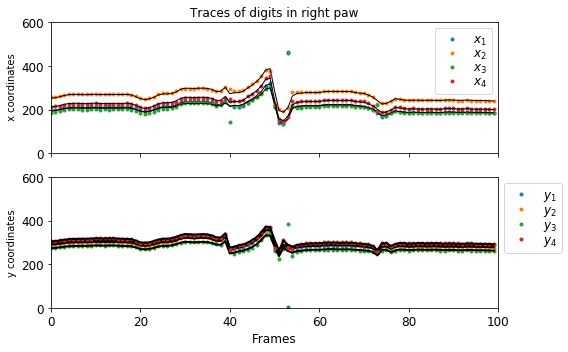

In [18]:
# Zoom in region where jump is high
_, D_obs = q_mf_y.shape
fontsize = 12
t0 = frame_idx[0] - 50
t = range(t0, t0+100)
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax[0].set_title('Traces of digits in right paw', fontsize=fontsize)
for d in range(D_obs//2):
    ax[0].plot(xr[d, t], '.', label='$ x_{}$'.format(d+1))
    ax[0].plot(q_mf_y[t, d], 'k-', lw=1)#, label='$\hat x''_{}$'.format(d+1), alpha=0.7)
    ax[0].set_ylim([0, 600])
    ax[0].set_xlim([0, len(t)])
    ax[0].legend(bbox_to_anchor=(1, 1), labelspacing=0, fontsize=fontsize)
    ax[0].set_ylabel(' x coordinates')
    ax[0].tick_params(labelsize=fontsize)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)

for d in range(D_obs//2):
    ax[1].plot(yr[d, t], '.', label='$y_{}$'.format(d+1))
    ax[1].plot(q_mf_y[t, d + 4], 'k-', lw=2)#, label='$\hat y''_{}$'.format(d+1), alpha=0.7)
    ax[1].set_ylim([0, 600])
    ax[1].set_xlim([0, len(t)])
    ax[1].legend(bbox_to_anchor=(1, 1), labelspacing=0, fontsize=fontsize)
    ax[1].set_ylabel('y coordinates')
    ax[1].tick_params(labelsize=fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)

ax[1].set_xlabel('Frames', fontsize=fontsize)
#plt.xlabel('Frames', fontsize=fontsize)
plt.tight_layout()
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


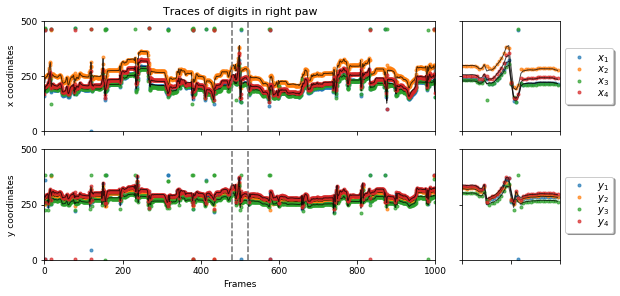

In [19]:
# Make scaled plot
import matplotlib.font_manager

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 9,
                            'xtick.labelsize' : 9,
                            'ytick.labelsize' : 9,
                            'axes.titlesize' : 11})

_, D_obs = q_mf_y.shape
t0 = frame_idx[0] - 500
t = range(t0, t0+1000)

    
t0short = frame_idx[0] - 20
tshort = range(t0short, t0short+40)

ylim = [0, 500]
yticks = np.linspace(ylim[0], ylim[1],3)

widths = [4, 1]
gs_kw = dict(width_ratios=widths,wspace=0.01)
fig, ax = plt.subplots(2, 2, figsize=(8.5, 4), sharex='col', sharey='row',
                       constrained_layout=True, gridspec_kw=gs_kw)
ax = ax.flatten(order='F')
ax[0].set_title('Traces of digits in right paw')
for d in range(D_obs//2):
    ax[0].plot(xr[d, t], '.', label='$ x_{}$'.format(d+1), alpha=0.7)
    ax[0].plot(q_mf_y[t, d], 'k-', lw=1, alpha=0.7)
    ax[0].set_ylim(ylim)
    ax[0].set_yticks(yticks)
    ax[0].set_ylabel(' x coordinates')
    ax[0].axvline(x=tshort[0] - t[0],linestyle='--', color='gray', alpha=0.5)
    ax[0].axvline(x=tshort[0] - t[0] + len(tshort),linestyle='--', color='gray', alpha=0.5)
    
for d in range(D_obs//2):
    ax[1].plot(yr[d, t], '.', label='$y_{}$'.format(d+1), alpha=0.7)
    ax[1].plot(q_mf_y[t, d + 4], 'k-', lw=1, alpha=0.7)
    ax[1].set_ylim(ylim)
    ax[1].set_yticks(yticks)
    ax[1].set_xlim([0, len(t)])
    ax[1].set_ylabel('y coordinates')
    ax[1].axvline(x=tshort[0] - t[0],linestyle='--', color='gray', alpha=0.5)
    ax[1].axvline(x=tshort[0] - t[0] + len(tshort),linestyle='--', color='gray', alpha=0.5)

for d in range(D_obs//2):
    ax[2].plot(xr[d, tshort], '.', label='$ x_{}$'.format(d+1), alpha=0.7)
    ax[2].plot(q_mf_y[tshort, d], 'k-', lw=1, alpha=0.7)
    ax[2].legend(loc='center left',bbox_to_anchor=(1, 0.5), labelspacing=0,fancybox=True, shadow=True)

for d in range(D_obs//2):
    ax[3].plot(yr[d, tshort], '.', label='$y_{}$'.format(d+1), alpha=0.7)
    ax[3].plot(q_mf_y[tshort, d + 4], 'k-', lw=1, alpha=0.7)
    ax[3].set_xlim([0, len(tshort)])
    ax[3].legend(loc='center left',bbox_to_anchor=(1, 0.5), labelspacing=0,fancybox=True, shadow=True)
    ax[3].set_xticklabels([])

ax[1].set_xlabel('Frames')
#plt.xlabel('Frames', fontsize=fontsize)
plt.tight_layout()
plt.savefig('outlier_right_paw.pdf')
plt.show()

46948


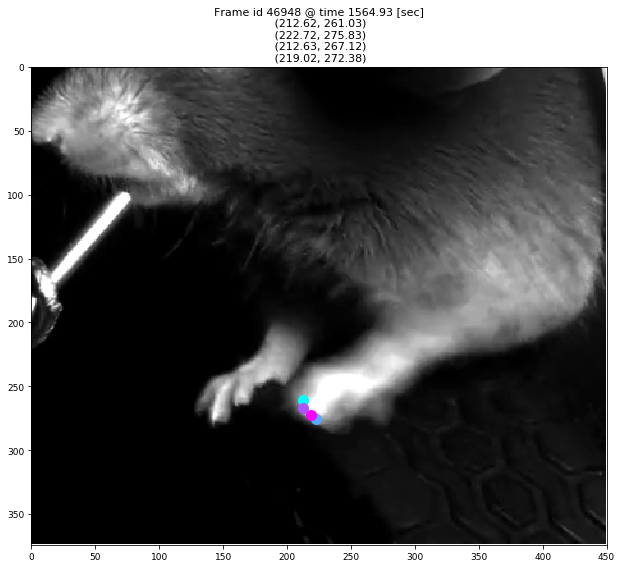

[False False  True False False False  True False]


In [20]:
visualize_frames(clip,xr, yr,t0=frame_idx[0])
print(mask[frame_idx[0],:])


In [21]:
# Store preprocessed traces
filename = exp_files.get_trace_preprocessed_fname()
# store
if not os.path.isfile(filename):
    print('Storing output in:\n{}'.format(filename))
    np.save(filename, (xr_hat.T, yr_hat.T, namer))
else:
    print('File exists! Manually overwrite output in:\n{}'.format(filename))

File exists! Manually overwrite output in:
/data/model_01/subject_02/preprocess/right_paw/paw_traces.npy


In [22]:
# Load preprocessed traces
(mean_x, mean_y, name) = exp_files.load_trace_preprocessed()

In [23]:
# Extract features through quantile transforms
xrmp, _, _ = quantile_scaling(mean_x)
yrmp, _, _ = quantile_scaling(mean_y)

In [24]:
# stack features for model
data = np.stack((xrmp, yrmp)).T
# add timescale
T = data.shape[0]
# add timestamps
timestamps = np.arange(T)

In [25]:
from behdata.utils_model import split_train_test_multiple, fit_gaussian
from behdata.video import zoom_in_coordinates

In [26]:
(train_, val_, test_) = split_train_test_multiple([data], [timestamps],
                                                seed=0, chunk=5000,
                                               verbose=False)
(train_data, train_slice) = train_
(val_data, val_slice) = val_
(test_data, test_slice) = test_

reference_train = fit_gaussian(train_data)
reference_val = fit_gaussian(val_data)
reference_test = fit_gaussian(test_data)
print(np.round([reference_train.sum()/len(reference_train),
       reference_val.sum()/len(reference_val),
       reference_test.sum()/len(reference_test)
      ],2))

[-0.6  -0.06 -0.42]


In [27]:
# make a clip of one of the videos
ii = 1 # select a train slice
rectangle_size = 50 # select size of rectangle where to zoom in on data
fps = clip.fps # frames per second
chunk = train_slice[ii]

xr_chunk = xr_hat.T[chunk]
yr_chunk = yr_hat.T[chunk]

# focus on the center
xr_chunk = np.nanmean(xr_chunk, 1)
yr_chunk = np.nanmean(yr_chunk, 1)

t_start, t_end = chunk[0]/fps , chunk[-1]/fps
subclip = clip.subclip(t_start=t_start, t_end=t_end)
print(subclip.duration)
#subclip.write_videofile('sample_chunk.mp4', verbose=False)
video_data_cropped = zoom_in_coordinates(subclip,
                                         xr_chunk,
                                         yr_chunk,
                                         rectangle_size=rectangle_size)
print(video_data_cropped.duration)
video_data_cropped.write_videofile('sample_chunk_zoomed.mp4',verbose=False)

166.63333333333333
Time frame @ 0 [sec] is 0 [idx]

166.63333333333333
Moviepy - Building video sample_chunk_zoomed.mp4.
Moviepy - Writing video sample_chunk_zoomed.mp4



t:   0%|          | 0/4999 [00:00<?, ?it/s, now=None]

Time frame @ 0.0 [sec] is 0 [idx]



t:  17%|█▋        | 873/4999 [00:00<00:03, 1346.84it/s, now=None]

Time frame @ 33.333333333333336 [sec] is 1000 [idx]



t:  37%|███▋      | 1872/4999 [00:01<00:01, 1628.12it/s, now=None]

Time frame @ 66.66666666666667 [sec] is 2000 [idx]



t:  58%|█████▊    | 2895/4999 [00:01<00:01, 1578.83it/s, now=None]

Time frame @ 100.0 [sec] is 3000 [idx]



t:  80%|███████▉  | 3988/4999 [00:02<00:00, 1812.37it/s, now=None]

Time frame @ 133.33333333333334 [sec] is 4000 [idx]



Moviepy - Done !
Moviepy - video ready sample_chunk_zoomed.mp4


In [28]:
# Store chunks split for validation train and test datasets
filename = exp_files.get_trace_features_fname()
# 
# store
if not os.path.isfile(filename):
    print('Storing output in:\n{}'.format(filename))
    np.save(filename, (train_, val_, test_))
else:
    print('File exists! Manually overwrite output in:\n{}'.format(filename))

File exists! Manually overwrite output in:
/data/model_01/subject_02/features/right_paw/features.npy
